In [1]:
!pip install tensorflow pandas==1.2.3 sklearn numpy transformers pandas-profiling

     |████████████████████████████████| 9.9MB 8.9MB/s 
     |████████████████████████████████| 2.3MB 36.1MB/s 
     |████████████████████████████████| 901kB 47.0MB/s 
     |████████████████████████████████| 3.3MB 47.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [2]:
import tensorflow as tf
import os
print(f"Tensorflow version: {tf.__version__}")

# Restrict TensorFlow to only allocate 4GBs of memory on the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[0],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    #tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"The system contains '{len(gpus)}' Physical GPUs and '{len(logical_gpus)}' Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
    print(f"Your system does not contain a GPU that could be used by Tensorflow!")

Tensorflow version: 2.4.1
The system contains '1' Physical GPUs and '1' Logical GPUs


In [3]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.model_selection import train_test_split

from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer)

from tqdm import tqdm

## Prepare data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip drive/MyDrive/nlp/dataset.zip

Archive:  drive/MyDrive/nlp/dataset.zip
  inflating: dataset.csv             


In [9]:
data = pd.read_csv('dataset.csv', encoding="latin-1")

data = data[['text', 'sentiment']]

data['sentiment'] = data['sentiment'].astype('category')

# Transform sentiment values to integers
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

data = data[data['text'].isnull() == False]

In [10]:
num_labels = data['sentiment'].max() + 1

In [11]:
X = (np.array(data['text']))
y = (np.array(data['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1} \nValidation dataset shape: {2}".format(X_train.shape, X_test.shape, X_val.shape))

Train dataset shape: (78129,), 
Test dataset shape: (9767,) 
Validation dataset shape: (9766,)


In [12]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

## Training BERT for classification

In [35]:
from transformers import TFBertPreTrainedModel, TFBertMainLayer

class TFBertForSentimentClassification(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.bert = TFBertMainLayer(config, name="bert", trainable = False)
        
        self.dropout = tf.keras.layers.Dropout(rate=config.hidden_dropout_prob)
        self.encoder = tf.keras.layers.Dense(
            units=10,
            name="encoder",
        )

        self.classifier = tf.keras.layers.Dense(
            units=config.num_labels,
            name="classifier",
        )

    def call(self, inputs, training = False, **kwargs):        
        outputs = self.bert(inputs, training = training, **kwargs)

        pooled_output = outputs[1]
        
        pooled_output = self.dropout(inputs=pooled_output, training=training)
        
        embedding = self.encoder(inputs=pooled_output)
        return embedding
        
        # logits = self.classifier(inputs=embedding)
        # return tf.nn.softmax(logits)

In [36]:
# bert_model = TFBertForSentimentClassification.from_pretrained("bert-base-cased", num_labels=num_labels)
# bert_model = TFBertForSentimentClassification.from_pretrained('./')
# bert_model = TFBertForSentimentClassification.from_pretrained('./drive/MyDrive/nlp/bert_sentiment_classification.h5')
bert_model = TFBertForSentimentClassification.from_pretrained('./drive/MyDrive/nlp/bert_sentiment_classification_softmax')

Some layers from the model checkpoint at ./drive/MyDrive/nlp/bert_sentiment_classification_softmax were not used when initializing TFBertForSentimentClassification: ['dropout_75', 'classifier/kernel:0', 'classifier/bias:0']
- This IS expected if you are initializing TFBertForSentimentClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSentimentClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSentimentClassification were not initialized from the model checkpoint at ./drive/MyDrive/nlp/bert_sentiment_classification_softmax and are newly initialized: ['dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use i

We prepare the input for the classifier (semi-manually using *encode_plus* method):

* *input_ids* contain id of each token from the tokenizer vocabulary
* *attention_masks* identify which is used to avoid using attention mechanism on padded tokens
* *token_type_ids* represent the sequence part of the input

In [14]:
pad_token=0
pad_token_segment_id=0
max_length=128

def convert_to_input(reviews):
  input_ids,attention_masks,token_type_ids=[],[],[]
  
  for x in tqdm(reviews, position=0, leave=True):
    inputs = bert_tokenizer.encode_plus(x,add_special_tokens=True, max_length=max_length)
    
    i, t = inputs["input_ids"], inputs["token_type_ids"]
    m = [1] * len(i)

    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)
    
    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)
  
  return [np.asarray(input_ids), 
            np.asarray(attention_masks), 
            np.asarray(token_type_ids)]

In [15]:
X_train_input=convert_to_input(X_train)
X_test_input=convert_to_input(X_test)
X_val_input=convert_to_input(X_val)

100%|██████████| 9766/9766 [00:07<00:00, 1292.54it/s]


Tensorflow models by default take object of type [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as input for training or prediction. It allows for shuffling, splitting or automatic batch creation.

In [16]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y

train_ds = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train)).map(example_to_features).shuffle(100).batch(12).repeat(5)
val_ds=tf.data.Dataset.from_tensor_slices((X_val_input[0],X_val_input[1],X_val_input[2],y_val)).map(example_to_features).batch(12)
test_ds=tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(example_to_features).batch(12)

We set the parameters ffor training and train the model. As our model is already pretrained and contains a specific head for sequence classification, we can use it directly.

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [30]:
# Test loss computation on one observation
X, y = next(train_ds.take(1).as_numpy_iterator())
y_pred = bert_model(X)
l = loss(y, y_pred).numpy()
l

2.782191

In [31]:
print("Fine-tuning BERT")
bert_history = bert_model.fit(train_ds, epochs=3, validation_data=val_ds)

Fine-tuning BERT
Epoch 1/3
 4942/32555 [===>..........................] - ETA: 56:21 - loss: 2.7415 - accuracy: 0.3425

KeyboardInterrupt: ignored

The fine-tuning will output something similar to the following:

```
Fine-tuning BERT on IMDB dataset
Train for 16670 steps, validate for 417 steps
Epoch 1/3
16670/16670 [==] - 5116s 307ms/step - loss: 0.1515 - accuracy: 0.9392 - val_loss: 0.5599 - val_accuracy: 0.8676
Epoch 2/3
16670/16670 [==] - 5123s 307ms/step - loss: 0.0347 - accuracy: 0.9884 - val_loss: 0.4681 - val_accuracy: 0.8742
Epoch 3/3
16670/16670 [==] - 5136s 308ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.6523 - val_accuracy: 0.8668
```

We can observe that the loss is decreasing and the accuracy on the validation data is increasing. 

After training for a few epochs we evaluate the model against the test data. First we prepare true values as a numpy array:

In [32]:
# SAVING YOUR MODEL
bert_model.save_pretrained('./drive/MyDrive/nlp/bert_sentiment_classification_softmax')

In [38]:
embeddings = bert_model.predict(test_ds)

In [34]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(embeddings, axis=1)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.33715572847343095


In [40]:
np.save('./drive/MyDrive/nlp/bert_embeddings.npy', embeddings)

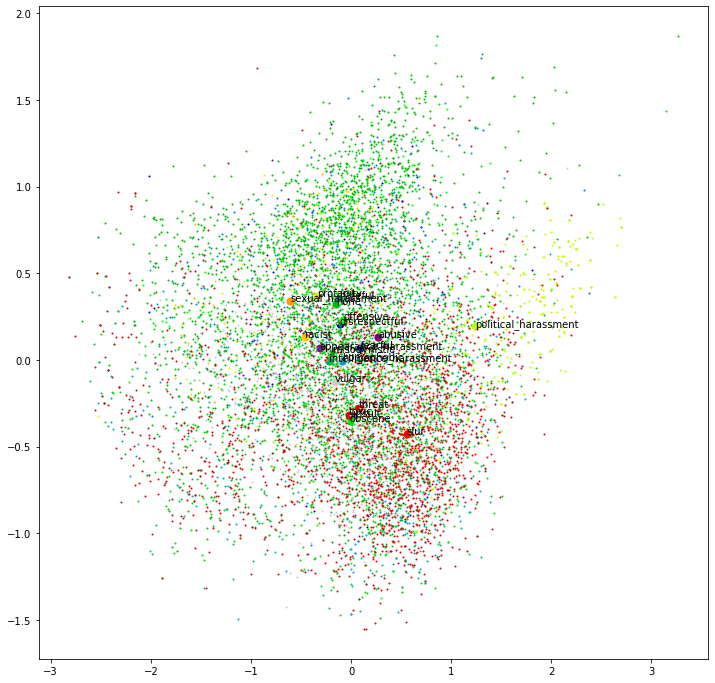

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt

def plot_embeding2(E, y):
  plt.figure(1,figsize=(12,12))
  cmap = plt.cm.get_cmap('nipy_spectral')

  for index in range(num_labels):
      cls_label = label_encoder.inverse_transform([index])[0]

      E_cls = E[y == index, :]

      color = cmap((index + 1) / num_labels)

      plt.scatter(E_cls[:,0], E_cls[:,1], color=color, s=1)
      E_mean = np.mean(E_cls, axis=0)
      
      plt.scatter(E_mean[0], E_mean[1], s=50, color=color)
      plt.annotate(cls_label, xy=(E_mean[0], E_mean[1]), size=10)

plot_embeding2(PCA(n_components = 2).fit_transform(embeddings), y_test)
plt.savefig('drive/MyDrive/nlp/bert_sent_embed_pca.png')

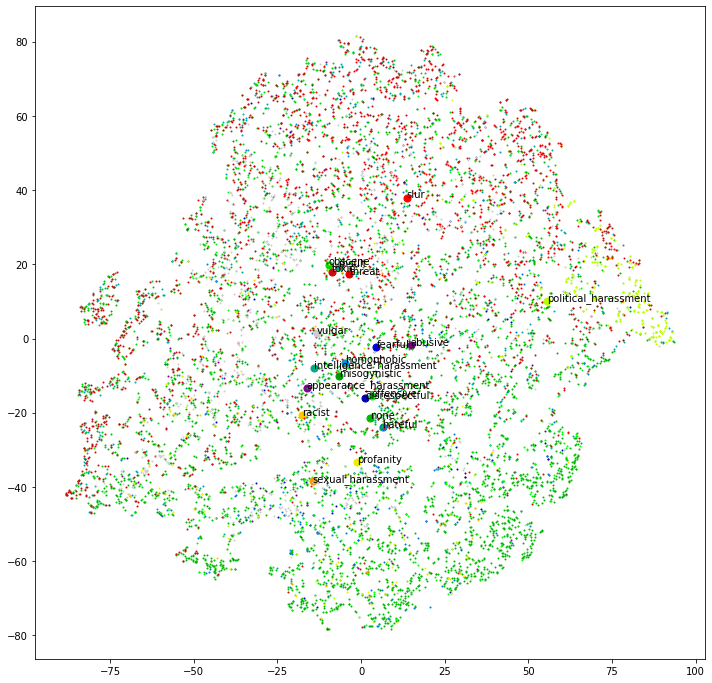

In [41]:
plot_embeding2(TSNE(n_components = 2).fit_transform(embeddings), y_test)
plt.savefig('drive/MyDrive/nlp/bert_sent_embed_tsne.png')

## Custom model including BERT

In [ ]:
from transformers import TFBertPreTrainedModel, TFBertMainLayer

class BertEmbeddingModel(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.bert = TFBertMainLayer(config, name="bert", trainable = False)
        
        self.classifier = tf.keras.layers.Dense(
            units=num_labels, name="classifier",
        )

    def call(self, inputs, training = False, **kwargs):        
        bert_outputs = self.bert(inputs, training = training, **kwargs)
        
        return self.classifier(bert_outputs[0])

In [ ]:
def get_token_ids(texts):
    return bert_tokenizer.batch_encode_plus(texts, 
                                            add_special_tokens=True, 
                                            max_length = 128, 
                                            pad_to_max_length = True)["input_ids"]

test_token_ids = get_token_ids(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
bert_model = BertEmbeddingModel.from_pretrained('./')

Some layers from the model checkpoint at ./ were not used when initializing BertEmbeddingModel: ['dropout_75']
- This IS expected if you are initializing BertEmbeddingModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEmbeddingModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of BertEmbeddingModel were initialized from the model checkpoint at ./.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertEmbeddingModel for predictions without further training.


In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_token_ids), tf.constant(y_test))).batch(12)

outputs = bert_model.predict(test_data)

In [ ]:
outputs = outputs[:, 127, :]

## Plain pretrained Bert



In [ ]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained("bert-base-cased", num_labels=num_labels)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def get_token_ids(texts):
    return bert_tokenizer.batch_encode_plus(texts, 
                                            add_special_tokens=True, 
                                            max_length = 128, 
                                            pad_to_max_length = True)["input_ids"]

test_token_ids = get_token_ids(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_token_ids), tf.constant(y_test))).batch(12)

outputs = bert_model.predict(test_data)
outputs = outputs[1]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
embeddings = outputs

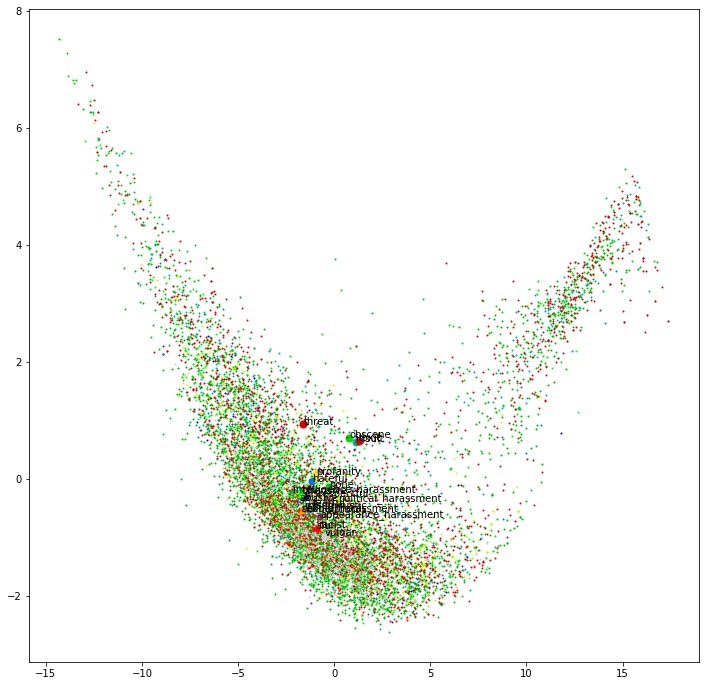

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
H = pca.fit_transform(embeddings)
    
plt.figure(1,figsize=(12,12))
cmap = plt.cm.get_cmap('nipy_spectral')

for index in range(num_labels):
    cls_label = label_encoder.inverse_transform([index])[0]

    H_cls = H[y_test == index, :]

    color = cmap((index + 1) / num_labels)

    plt.scatter(H_cls[:,0], H_cls[:,1], color=color, s=1)
    H_mean = np.mean(H_cls, axis=0)
    
    plt.scatter(H_mean[0], H_mean[1], s=50, color=color)
    plt.annotate(cls_label, xy=(H_mean[0], H_mean[1]), size=10)

plt.savefig('drive/MyDrive/nlp/bert_plain_pooled.png')